Anomaly Detction on Screws

Objectives:
EDA\
a. How many samples are there?\
b. Are the samples evenly distributed?\
c. What kind of anomalies are there?\
d. Is the data sufficient to train a model?\
e. What kind of problems can we expect?\
f. What can we do to improve the detection of anomalies in this data?\
g. Optional: Anything else that you think is important (graphs, visualizations, measurements…)\
\
Model\
a. Binary classifier\
b. Describe the model and why the choice\
c. Decide on how to split the data, the hyperparameters, the loss/evaluation functions, and describe why you have chosen these parameters.\
d. Evaluate the performance of your model\
e. the test data as an extra layer of evaluation and perform manual validation\
f. Reasons behind the results you obtain\
g. Reflect on any flaws in your method, or points that could have been done better\


IMPORTS

In [1]:
import gdown
from zipfile import ZipFile

In [ ]:
url = "https://drive.google.com/u/0/uc?id=11ozVs6zByFjs9viD3VIIP6qKFgjZwv9E&export=download"
output = "screws.zip"
gdown.download(url, output, quiet=False)

In [10]:
with ZipFile("./screws.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [546]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os, os.path
import random
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input, Sequential, layers, losses
from skimage import io
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve
from keras.models import load_model

In [151]:
#number of images
DIR_train_good = r"./archive/train/good"
DIR_train_notgood = r"./archive/train/not-good"
DIR_test = r"./archive/test"

X_train_good = [name for name in os.listdir(DIR_train_good) if os.path.isfile(os.path.join(DIR_train_good, name))]
X_train_not_good = [name for name in os.listdir(DIR_train_notgood) if os.path.isfile(os.path.join(DIR_train_notgood, name))]
X_test = [name for name in os.listdir(DIR_test) if os.path.isfile(os.path.join(DIR_test, name))]

print(len(X_train_good))
print(len(X_train_not_good))
print(len(X_test))

250
50
180


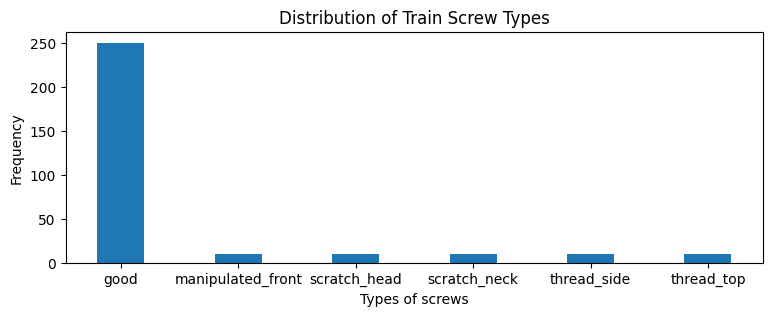

In [544]:
# Types of anomalies
Anomaly_suffix = [name[:-7] for name in X_train_not_good]
Anomaly_types, Anomaly_dist = np.unique(Anomaly_suffix, return_counts=True)

# Graph of distribution of anomalies and good
types = np.append("good", Anomaly_types)
counts = np.append(len(X_train_good), Anomaly_dist)
fig = plt.figure(figsize =(9, 3))
plt.bar(types, counts, width = 0.4)
plt.xlabel("Types of screws")
plt.ylabel("Frequency")
plt.title("Distribution of Train Screw Types")
plt.show()

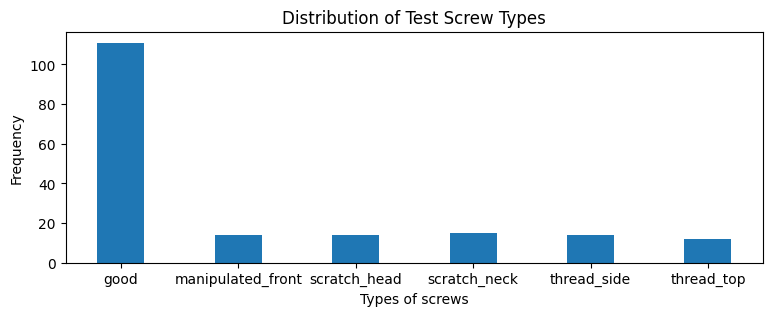

In [582]:
#Manually annotated
manipuated_front = [20, 29, 61, 77, 83, 84, 88, 107, 118, 121, 122, 146, 147, 159]
scratch_head = [96, 103, 115, 119, 126, 127, 149, 154, 158, 161, 165, 167, 173, 174]
scratch_neck = [109, 111, 117, 125, 128, 131, 133, 134, 136, 141, 148, 152, 157, 163, 166]
thread_side = [47, 85, 87, 94, 120, 137, 140, 142, 144, 145, 151, 153, 162, 168]
thread_top = [116, 124, 129, 130, 135, 138, 143, 150, 155, 156, 164, 175]
types = np.append("good", Anomaly_types)
count_notgood = [len(manipuated_front), len(scratch_head), len(scratch_neck), len(thread_side), len(thread_top)]
count_good = len(X_test) - sum(count_notgood)
counts = np.append(count_good, count_notgood)

fig = plt.figure(figsize =(9, 3))
plt.bar(types, counts, width = 0.4)
plt.xlabel("Types of screws")
plt.ylabel("Frequency")
plt.title("Distribution of Test Screw Types")
plt.show()

In [571]:
counts

array([111,  14,  14,  15,  14,  12])

In [589]:
#Preparing test dataset
idx_test_notgood = manipuated_front + scratch_head + scratch_neck + thread_side + thread_top
idx_test_good = [x for x in [*range(180)] if x not in idx_test_notgood]

X_test_good = ["test_" + str(i) + ".png" for i in idx_test_good]
X_test_notgood = ["test_" + str(i) + ".png" for i in idx_test_notgood]

### Hyper Parameters

In [574]:
random_seed = 255
test_size = 0.2
batch_size = 32
epochs = 100
input_dim = (200, 200)

In [463]:
loss_fn = losses.MeanSquaredError()

In [464]:
#Train and valiation split
X_train, X_val = train_test_split(X_train_good, test_size = test_size, random_state = random_seed, shuffle = True)


### Data Generator

In [539]:
#Data generator class to load images from array of filepaths
class Image_data_generator(tf.keras.utils.Sequence):
    def __init__(self, X_array, path, batch_size = batch_size, input_dim = input_dim, augment = 0):
        self.augment = augment
        if self.augment:
            self.image_data_generator = ImageDataGenerator(rescale=1. / 255, data_format='channels_last', rotation_range=20, horizontal_flip=True, vertical_flip=True)
        else:
            self.image_data_generator = ImageDataGenerator(rescale=1. / 255, data_format='channels_last')
        self.X_array = X_array
        self.path = path
        self.batch_size = batch_size
        self.input_dim = input_dim


    def load_image(self, path):
        image = cv2.imread(path, 0)
        image = np.expand_dims(image, axis=2)
        image = self.image_data_generator.random_transform(image, random_seed)
        image = image / 255                         #normalize
        image = tf.image.resize(image, self.input_dim)  #shape to tensor of input dim
        return image
    
    def __getitem__(self, index):
        img_array = []
        for i in range(self.batch_size):
            img_path = self.X_array[self.batch_size * index + i]
            img_array.append(self.load_image(self.path + img_path))
        img_array = np.array(img_array)
        return img_array, img_array      #input and prediction are same for autoencoder
    
    def __len__(self):
        return len(self.X_array)//self.batch_size
    


In [490]:
#Train and validation generator
train_generator = Image_data_generator(X_train, path = r"./archive/train/good/", augment=1)
val_generator = Image_data_generator(X_val, path = r"./archive/train/good/")

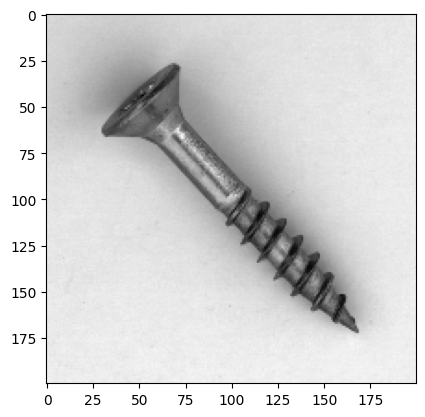

In [488]:
#test if generator working
x, _ = train_generator[0]
arr_ = np.squeeze(x[0])
plt.imshow(arr_, cmap='gray')
plt.show()

### Model

In [459]:
#Model
autoencoder = Sequential([
    #encode
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(200,200,1)),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(8, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), padding='same'),

    #decode
    # layers.Conv2D(8, (3, 3), padding='same', activation='relu'),
    # layers.UpSampling2D((2, 2)),
    # layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    # layers.UpSampling2D((2, 2)),
    # layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    # layers.UpSampling2D((2, 2)),
    layers.Conv2DTranspose(8, 3, strides=2, activation='relu', padding='same'),
    layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same'),
    layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same'),
    layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')
])

# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.compile(optimizer='adam', loss=loss_fn)
autoencoder.build(input_shape = (None, 200, 200, 1))
autoencoder.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_212 (Conv2D)         (None, 200, 200, 32)      320       
                                                                 
 max_pooling2d_99 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_213 (Conv2D)         (None, 100, 100, 16)      4624      
                                                                 
 max_pooling2d_100 (MaxPooli  (None, 50, 50, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_214 (Conv2D)         (None, 50, 50, 8)         1160      
                                                                 
 max_pooling2d_101 (MaxPooli  (None, 25, 25, 8)      

In [572]:
#Callback functions

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='./Models/autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

cb = [early_stop, save_model]

In [ ]:
#Train
history = autoencoder.fit(train_generator,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=val_generator,
                callbacks= cb)

In [ ]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [233]:
#load model from previous run
# autoencoder = load_model('autoencoder_best_weights2.hdf5')

1/1 [==============================] - 0s 100ms/step


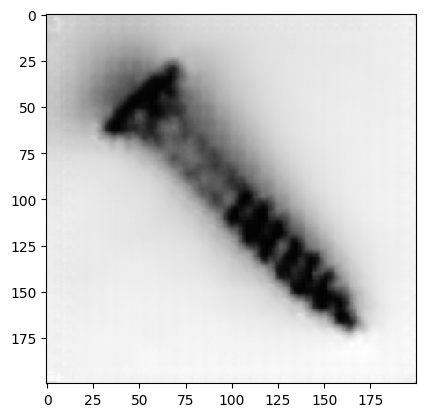

In [497]:
#check reconstruction on trained image
test_img = x[0]
test_img = np.expand_dims(test_img, axis=0)
recons_img = autoencoder.predict(test_img)
# io.imshow(recons_img[0])
# io.show()
arr_ = np.squeeze(recons_img[0])
plt.imshow(arr_, cmap='gray')
plt.savefig("recons_img.png")
plt.show()


### Evaluation
Histogram of error on Good and Not-good screws and decide threshold

In [513]:
# good_generator = Image_data_generator(X_train_good, path= r"./archive/train/good/", batch_size=1)
val_generator = Image_data_generator(X_train_good[0:50], path= r"./archive/train/good/", batch_size=1)
notgood_generator = Image_data_generator(X_train_not_good, path= r"./archive/train/not-good/", batch_size=1)


1/1 [==============================] - 0s 158ms/step


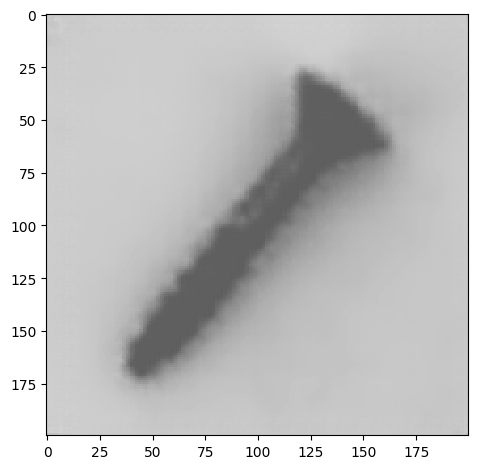

In [499]:
#check reconstruction on not-good image
test_img_NG_batch, _ = notgood_generator[0]
test_img_NG = test_img_NG_batch[0]
test_img_NG = np.expand_dims(test_img_NG, axis=0)
recons_img_NG = autoencoder.predict(test_img_NG)
io.imshow(recons_img_NG[0])
io.show()

In [514]:
#Prediction loss
predict_good = autoencoder.predict(val_generator)
predict_notgood = autoencoder.predict(notgood_generator)

error_good = [loss_fn(val_generator[i][0][0], predict_good[i]) for i in range(len(X_val))]
error_notgood = [loss_fn(notgood_generator[i][0][0], predict_notgood[i]) for i in range(len(X_train_not_good))]

error_total = error_good + error_notgood
y_total = ["good"]*len(X_val) + ["notgood"]*len(X_train_not_good)

50/50 [==============================] - 2s 33ms/step


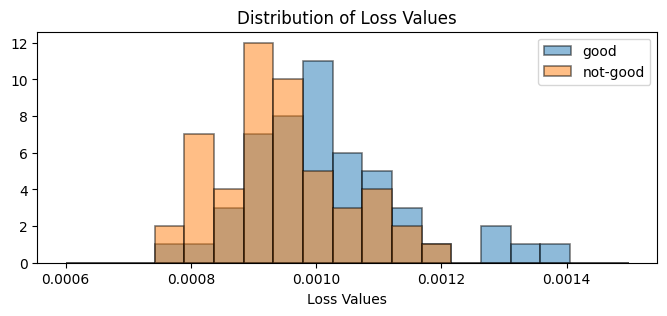

In [553]:
fig, ax = plt.subplots(figsize=(8,3))
bins = np.linspace(0.0006, 0.0015, 20)
plt.hist(error_good, bins, alpha=0.5, label='good', edgecolor='black', linewidth=1.2)
plt.hist(error_notgood, bins, alpha=0.5, label='not-good', edgecolor='black', linewidth=1.2)
plt.xlabel("Loss Values")
plt.title("Distribution of Loss Values")
plt.legend()
plt.show()

### Precision and Recall

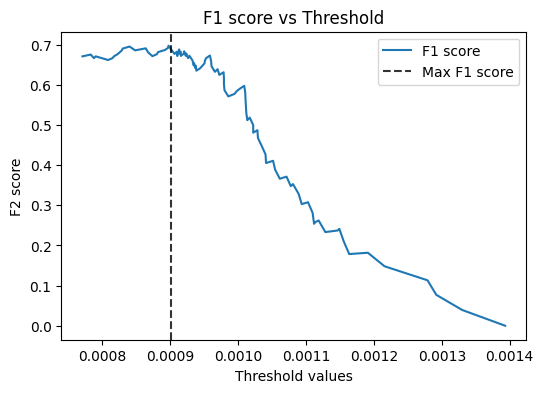

In [521]:
#Determine threshold to maximize F1 score
precision, recall, threshold = precision_recall_curve(y_total, error_total, pos_label="good")
f1_score = 2 * precision * recall / (precision + recall)

f1_max = f1_score[f1_score == max(f1_score)]
best_threshold = np.squeeze(threshold)[np.argmax(np.squeeze(f1_score))]

fig, ax = plt.subplots(figsize=(6,4))
plt.plot(threshold, f1_score[1: ], label = "F1 score")
ax.axvline(x=best_threshold, c='black', linestyle='--', alpha=.8, label="Max F1 score")
plt.xlabel("Threshold values")
plt.ylabel("F2 score")
plt.title("F1 score vs Threshold")
plt.legend()
plt.show()

In [517]:
loss_threshold = best_threshold

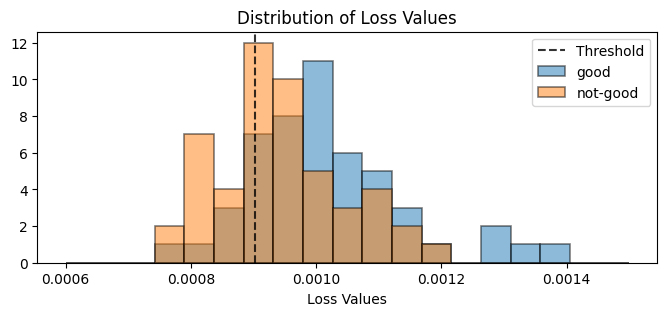

In [554]:
fig, ax = plt.subplots(figsize=(8,3))
bins = np.linspace(0.0006, 0.0015, 20)
ax.axvline(x=loss_threshold, c='black', linestyle='--', alpha=.8, label="Threshold")
plt.hist(error_good, bins, alpha=0.5, label='good', edgecolor='black', linewidth=1.2)
plt.hist(error_notgood, bins, alpha=0.5, label='not-good', edgecolor='black', linewidth=1.2)
plt.xlabel("Loss Values")
plt.title("Distribution of Loss Values")
plt.legend()
plt.show()

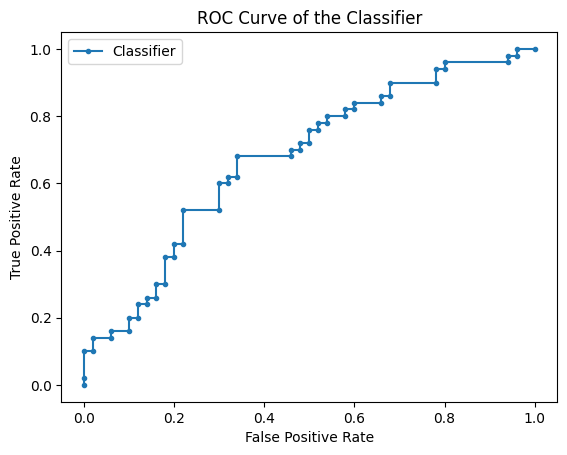

In [568]:
#roc curve
lr_fpr, lr_tpr, _ = roc_curve(y_total, error_total, pos_label="good")

plt.plot(lr_fpr, lr_tpr, marker='.', label='Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve of the Classifier")
plt.legend()
plt.show()

In [522]:
#class prediction with threshold & classification report
prediction_class = ["good" if i < loss_threshold else "notgood" for i in error_total]

report = classification_report(y_total, prediction_class)
print(report)

              precision    recall  f1-score   support

        good       0.24      0.10      0.14        50
     notgood       0.43      0.68      0.53        50

    accuracy                           0.39       100
   macro avg       0.33      0.39      0.33       100
weighted avg       0.33      0.39      0.33       100



### Prediction on Test Set

In [523]:
test_generator = Image_data_generator(X_test, path= r"./archive/test/", batch_size=1)
predict_test = autoencoder.predict(test_generator)
error_test = [loss_fn(test_generator[i][0][0], predict_test[i]) for i in range(len(X_test))]

180/180 [==============================] - 8s 42ms/step


In [599]:
class_pred = ["good" if i > loss_threshold else "notgood" for i in error_test]
counts = [1 if i == "good" else 0 for i in class_pred]
sum(counts)

115

In [ ]:
test_good_generator = Image_data_generator(X_test_good[0:69], path= r"./archive/test/", batch_size=1)
test_notgood_generator = Image_data_generator(X_test_notgood, path= r"./archive/test/", batch_size=1)

predict_test_good = autoencoder.predict(test_good_generator)
predict_test_notgood = autoencoder.predict(test_notgood_generator)

error_test_good = [loss_fn(test_good_generator[i][0][0], predict_test_good[i]) for i in range(len(X_test_good[0:69]))]
error_test_notgood = [loss_fn(test_notgood_generator[i][0][0], predict_test_notgood[i]) for i in range(len(X_test_notgood))]

error_test_total = error_test_good + error_test_notgood
y_total = ["good"]*len(X_test_good) + ["notgood"]*len(X_test_notgood)

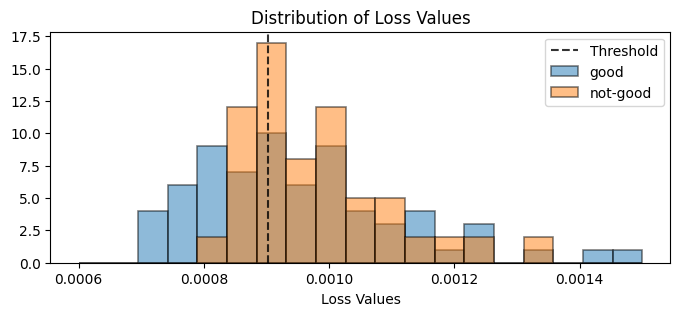

In [598]:
fig, ax = plt.subplots(figsize=(8,3))
bins = np.linspace(0.0006, 0.0015, 20)
ax.axvline(x=loss_threshold, c='black', linestyle='--', alpha=.8, label="Threshold")
plt.hist(error_test_good, bins, alpha=0.5, label='good', edgecolor='black', linewidth=1.2)
plt.hist(error_test_notgood, bins, alpha=0.5, label='not-good', edgecolor='black', linewidth=1.2)
plt.xlabel("Loss Values")
plt.title("Distribution of Loss Values")
plt.legend()
plt.show()